In [15]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import os
projectDir = 'C:/repos/kaggle/Sberbank'

from sklearn import model_selection, preprocessing
import xgboost as xgb

%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 500)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

# from subprocess import check_output
# print(check_output(os.path.join(projectDir,"input/")).decode("utf8"))

# Any results you write to the current directory are saved as output.

In [17]:
train_df = pd.read_csv(os.path.join(projectDir,"input/train.csv")) 
train_df.shape

(30471, 292)

In [18]:
train_df.head()

In [19]:
train_df = pd.read_csv("../input/train.csv", parse_dates=['timestamp'])
train_df['price_doc_log'] = np.log1p(train_df['price_doc'])

FileNotFoundError: File b'../input/train.csv' does not exist

In [20]:
train_df.isnull().sum()

id                                           0
timestamp                                    0
full_sq                                      0
life_sq                                   6383
floor                                      167
max_floor                                 9572
material                                  9572
build_year                               13605
num_room                                  9572
kitch_sq                                  9572
state                                    13559
product_type                                 0
sub_area                                     0
area_m                                       0
raion_popul                                  0
green_zone_part                              0
indust_part                                  0
children_preschool                           0
preschool_quota                           6688
preschool_education_centers_raion            0
children_school                              0
school_quota 

In [21]:
train_df.index

RangeIndex(start=0, stop=30471, step=1)

In [22]:
train_na = (train_df.isnull().sum() / len(train_df)) * 100
train_na = train_na.drop(train_na[train_na == 0].index).sort_values(ascending=False)

C:\Users\seb\Anaconda3\envs\trade\lib\site-packages\seaborn\categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


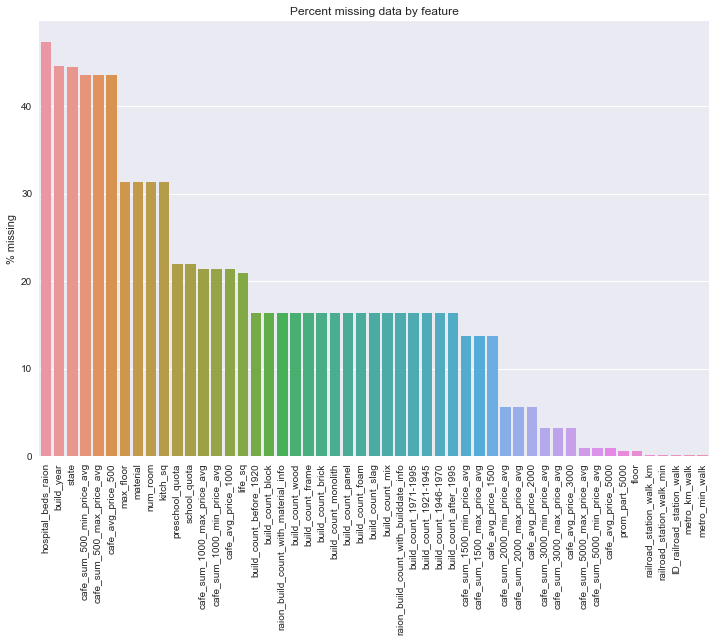

In [23]:
f, ax = plt.subplots(figsize=(12, 8))
plt.xticks(rotation='90')
sns.barplot(x=train_na.index, y=train_na)
ax.set(title='Percent missing data by feature', ylabel='% missing')

In [24]:
#train_df['state'][:50]
#train_df['state'].unique()
train_df['state'].value_counts()

2.0     5844
3.0     5790
1.0     4855
4.0      422
33.0       1
Name: state, dtype: int64

In [25]:
train_df.loc[train_df['state']==33, 'state'] = train_df['state'].mode().iloc[0]

In [26]:
train_df['state'].value_counts()

2.0    5845
3.0    5790
1.0    4855
4.0     422
Name: state, dtype: int64

In [27]:
train_df['build_year'].value_counts()

2014.0        919
2015.0        824
0.0           530
2013.0        464
1970.0        418
1969.0        407
1968.0        389
1967.0        384
1965.0        378
2016.0        375
1.0           368
1972.0        360
1974.0        357
1971.0        352
1966.0        348
1960.0        344
1962.0        338
1973.0        333
1963.0        325
1964.0        315
1975.0        309
1961.0        297
1976.0        263
1977.0        260
2006.0        242
1979.0        236
1978.0        235
2008.0        234
2012.0        233
1980.0        226
             ... 
1912.0          5
1947.0          4
1949.0          3
1914.0          3
1924.0          3
1941.0          2
3.0             2
1943.0          2
1860.0          2
1896.0          2
1946.0          2
1907.0          2
1900.0          2
1895.0          1
1691.0          1
20052009.0      1
1911.0          1
2018.0          1
215.0           1
1886.0          1
1905.0          1
4965.0          1
1906.0          1
1920.0          1
1925.0    

In [28]:
train_df.loc[train_df['build_year'] == 20052009, 'build_year'] = 2007
#build_year has an erronus value 20052009. Since its unclear which it should be, let's replace with 2007

In [29]:
train_1900= train_df[train_df['build_year'] < 1900]
train_1900.shape

(916, 292)

In [30]:
internal_chars = ['full_sq', 'life_sq', 'floor', 'max_floor', 'build_year', 'num_room', 'kitch_sq', 'state', 'price_doc']
corrmat = train_df[internal_chars].corr()

C:\Users\seb\Anaconda3\envs\trade\lib\site-packages\seaborn\matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
C:\Users\seb\Anaconda3\envs\trade\lib\site-packages\seaborn\matrix.py:151: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


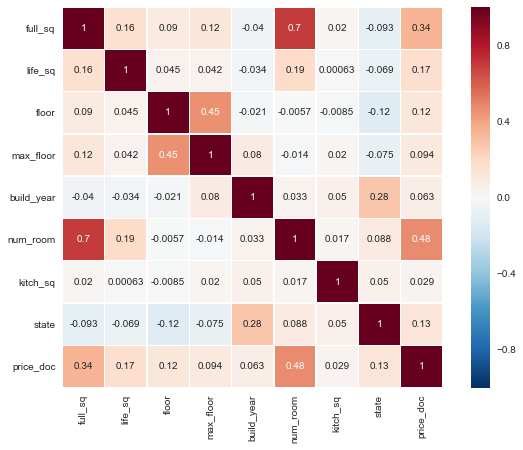

In [31]:
f, ax = plt.subplots(figsize=(10, 7))
plt.xticks(rotation='90')
sns.heatmap(corrmat, square=True, linewidths=.5, annot=True)

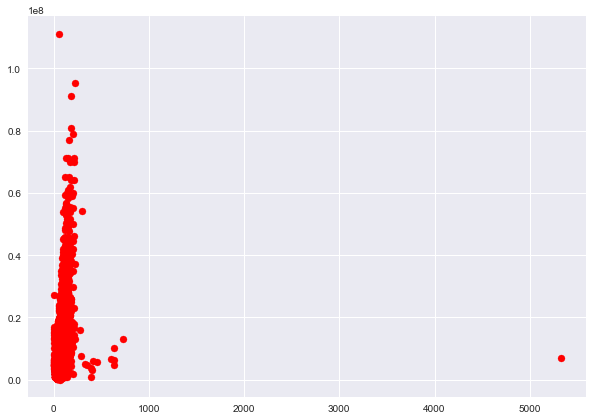

In [32]:
#x= full_sq, y=price_doc
f, ax = plt.subplots(figsize=(10, 7))
plt.scatter(x=train_df['full_sq'], y=train_df['price_doc'], c='r')

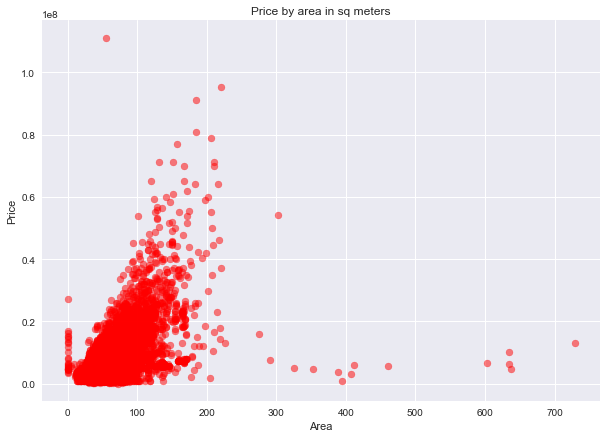

In [33]:
f, ax = plt.subplots(figsize=(10, 7))
ind = train_df[train_df['full_sq'] > 2000].index
plt.scatter(x=train_df.drop(ind)['full_sq'], y=train_df.drop(ind)['price_doc'], c='r', alpha=0.5)
ax.set(title='Price by area in sq meters', xlabel='Area', ylabel='Price')

In [34]:
(train_df['life_sq'] > train_df['full_sq']).sum()

37

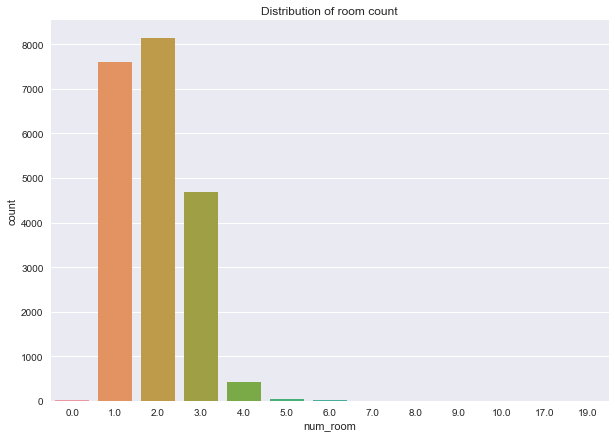

In [35]:
f, ax = plt.subplots(figsize=(10, 7))
sns.countplot(x=train_df['num_room'])
ax.set(title='Distribution of room count', xlabel='num_room')

In [36]:
train_df.groupby('product_type')['price_doc'].median()

product_type
Investment       6670000
OwnerOccupier    5564090
Name: price_doc, dtype: int64

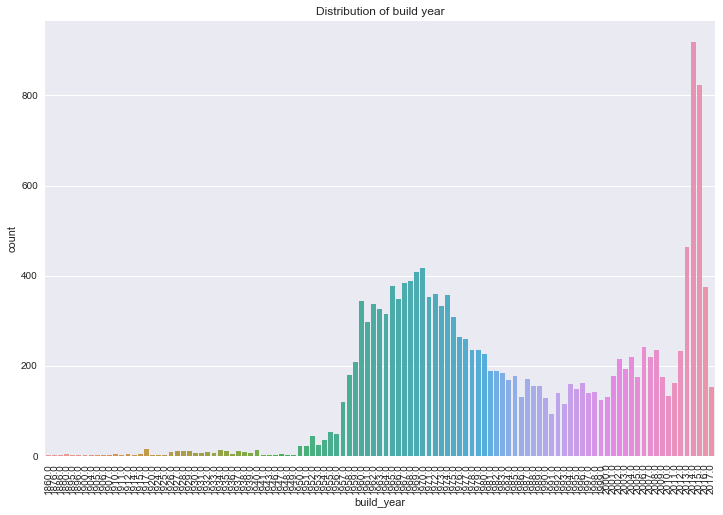

In [37]:
f, ax = plt.subplots(figsize=(12, 8))
plt.xticks(rotation='90')
ind = train_df[(train_df['build_year'] <= 1691) | (train_df['build_year'] >= 2018)].index
by_df = train_df.drop(ind).sort_values(by=['build_year'])
sns.countplot(x=by_df['build_year'])
ax.set(title='Distribution of build year')

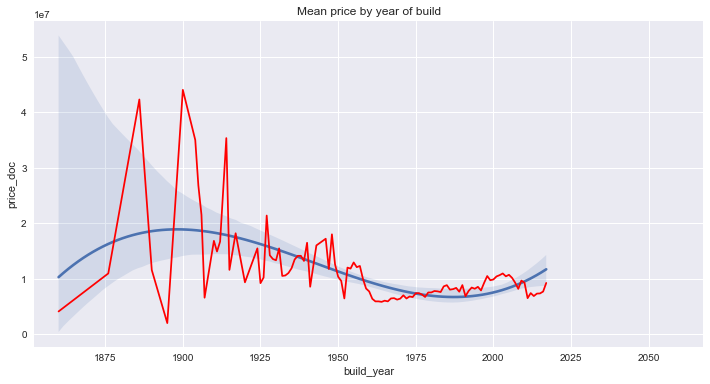

In [38]:
f, ax = plt.subplots(figsize=(12, 6))
by_price = by_df.groupby('build_year')[['build_year', 'price_doc']].mean()
sns.regplot(x="build_year", y="price_doc", data=by_price, scatter=False, order=3, truncate=True)
plt.plot(by_price['build_year'], by_price['price_doc'], color='r')
ax.set(title='Mean price by year of build')

ValueError: could not convert string to float: '2015-06-30'

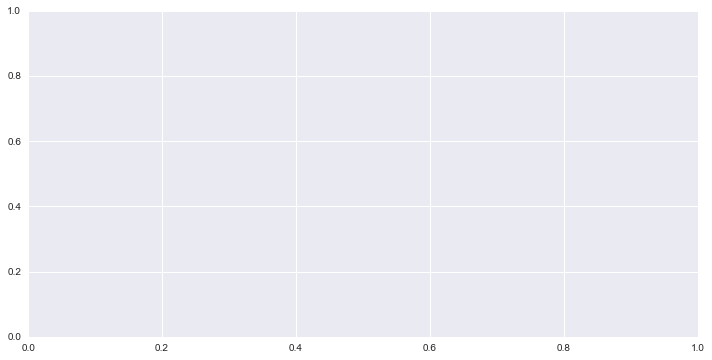

In [39]:
f, ax = plt.subplots(figsize=(12, 6))
ts_df = train_df.groupby('timestamp')[['price_doc']].mean()
#sns.regplot(x="timestamp", y="price_doc", data=ts_df, scatter=False, truncate=True)
plt.plot(ts_df.index, ts_df['price_doc'], color='r', )
ax.set(title='Daily median price over time')

TypeError: unsupported operand type(s) for -: 'str' and 'float'

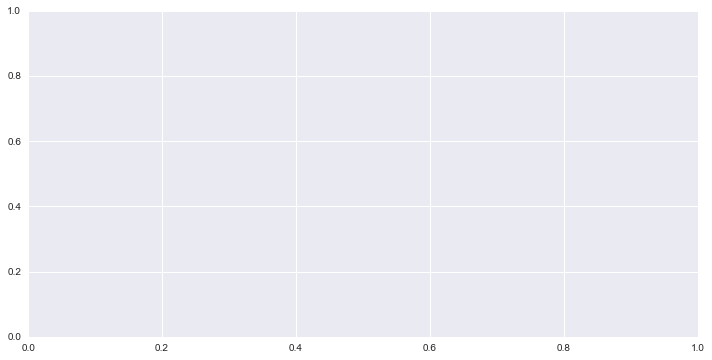

In [40]:
import datetime
import matplotlib.dates as mdates

years = mdates.YearLocator()   # every year
yearsFmt = mdates.DateFormatter('%Y')
ts_vc = train_df['timestamp'].value_counts()

f, ax = plt.subplots(figsize=(12, 6))
plt.bar(left=ts_vc.index, height=ts_vc)
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.set(title='Sales volume over time', ylabel='Number of transactions')

AttributeError: Can only use .dt accessor with datetimelike values

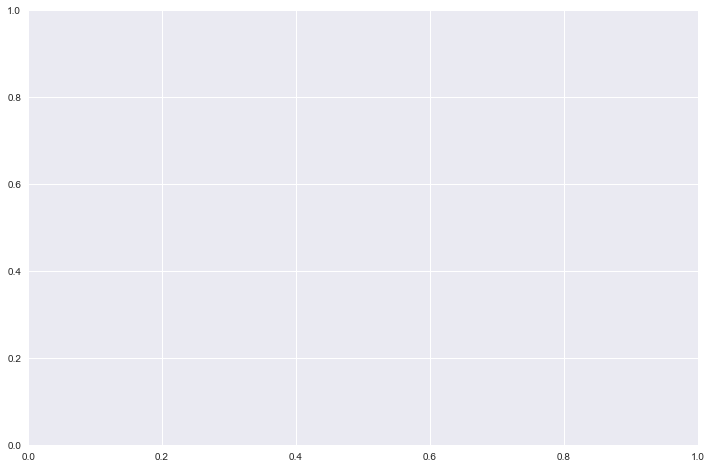

In [41]:
f, ax = plt.subplots(figsize=(12, 8))
ts_df = train_df.groupby(by=[train_df.timestamp.dt.month])[['price_doc']].median()
plt.plot(ts_df.index, ts_df, color='r')
ax.set(title='Price by month of year')

C:\Users\seb\Anaconda3\envs\trade\lib\site-packages\seaborn\categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


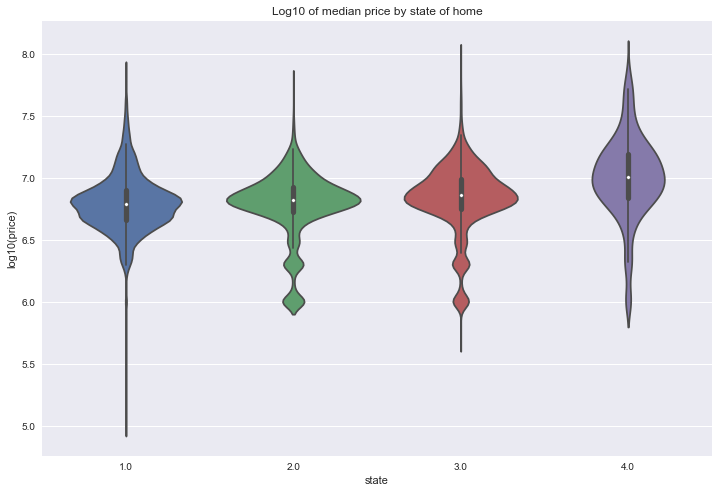

In [42]:
f, ax = plt.subplots(figsize=(12, 8))
ind = train_df[train_df['state'].isnull()].index
train_df['price_doc_log10'] = np.log10(train_df['price_doc'])
sns.violinplot(x="state", y="price_doc_log10", data=train_df.drop(ind), inner="box")
# sns.swarmplot(x="state", y="price_doc_log10", data=train_df.dropna(), color="w", alpha=.2);
ax.set(title='Log10 of median price by state of home', xlabel='state', ylabel='log10(price)')

In [43]:
train_df.drop(ind).groupby('state')['price_doc'].mean()

state
1.0    7.315440e+06
2.0    7.060396e+06
3.0    8.078316e+06
4.0    1.334547e+07
Name: price_doc, dtype: float64

ValueError: Could not interpret input 'price_doc_log'

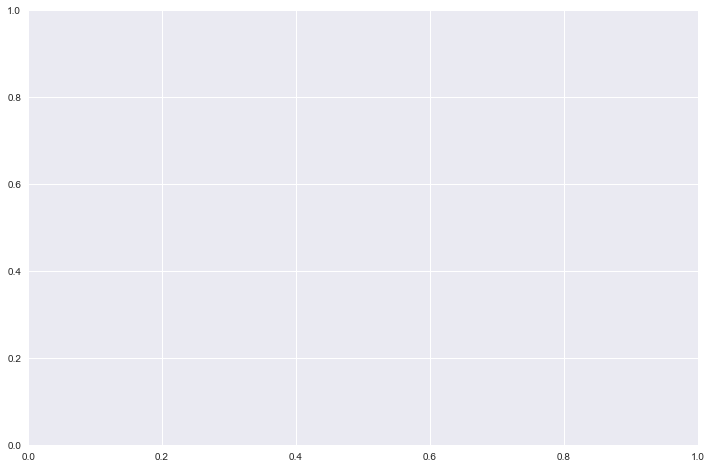

In [44]:
f, ax = plt.subplots(figsize=(12, 8))
ind = train_df[train_df['material'].isnull()].index
sns.violinplot(x="material", y="price_doc_log", data=train_df.drop(ind), inner="box")
# sns.swarmplot(x="state", y="price_doc_log10", data=train_df.dropna(), color="w", alpha=.2);
ax.set(title='Distribution of price by build material', xlabel='material', ylabel='log(price)')

KeyError: 'price_doc_log'

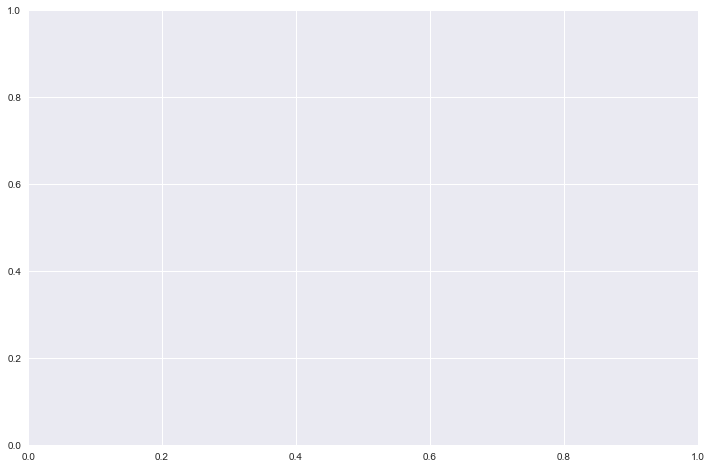

In [45]:
f, ax = plt.subplots(figsize=(12, 8))
plt.scatter(x=train_df['floor'], y=train_df['price_doc_log'], c='r', alpha=0.4)
sns.regplot(x="floor", y="price_doc_log", data=train_df, scatter=False, truncate=True)
ax.set(title='Price by floor of home', xlabel='floor', ylabel='log(price)')

KeyError: 'price_doc_log'

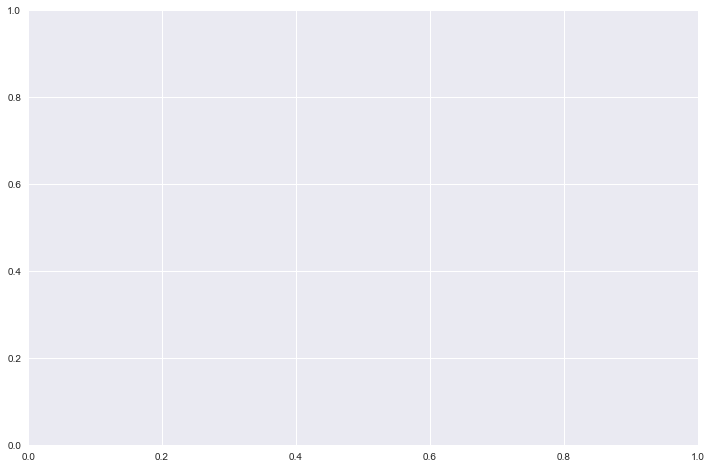

In [46]:
f, ax = plt.subplots(figsize=(12, 8))
plt.scatter(x=train_df['max_floor'], y=train_df['price_doc_log'], c='r', alpha=0.4)
sns.regplot(x="max_floor", y="price_doc_log", data=train_df, scatter=False, truncate=True)
ax.set(title='Price by max floor of home', xlabel='max_floor', ylabel='log(price)')

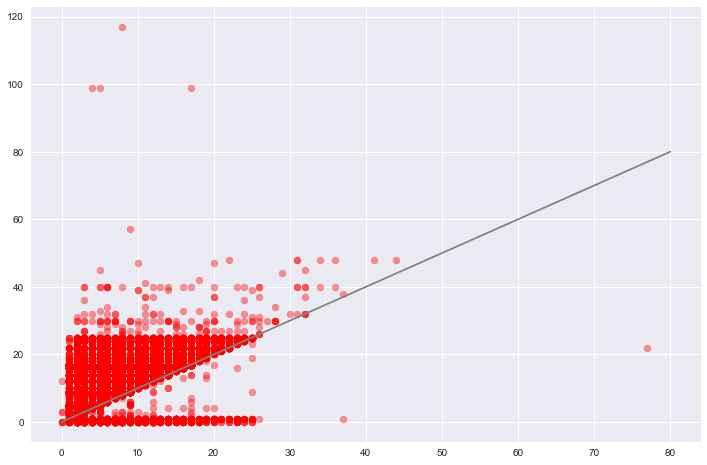

In [47]:
f, ax = plt.subplots(figsize=(12, 8))
plt.scatter(x=train_df['floor'], y=train_df['max_floor'], c='r', alpha=0.4)
plt.plot([0, 80], [0, 80], color='.5')

In [48]:
train_df.loc[train_df['max_floor'] < train_df['floor'], ['id', 'floor','max_floor']].head(20)

,id,floor,max_floor
8216,8219,13.0,0.0
8268,8271,3.0,1.0
8499,8502,2.0,0.0
8531,8534,7.0,0.0
8912,8915,5.0,0.0
9161,9164,8.0,3.0
9257,9260,8.0,1.0
9309,9312,5.0,1.0
9388,9391,10.0,1.0
9412,9415,4.0,1.0


In [49]:
## Demographic Characteristics
demo_vars = ['area_m', 'raion_popul', 'full_all', 'male_f', 'female_f', 'young_all', 'young_female', 
             'work_all', 'work_male', 'work_female', 'price_doc']
corrmat = train_df[demo_vars].corr()

C:\Users\seb\Anaconda3\envs\trade\lib\site-packages\seaborn\matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
C:\Users\seb\Anaconda3\envs\trade\lib\site-packages\seaborn\matrix.py:151: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


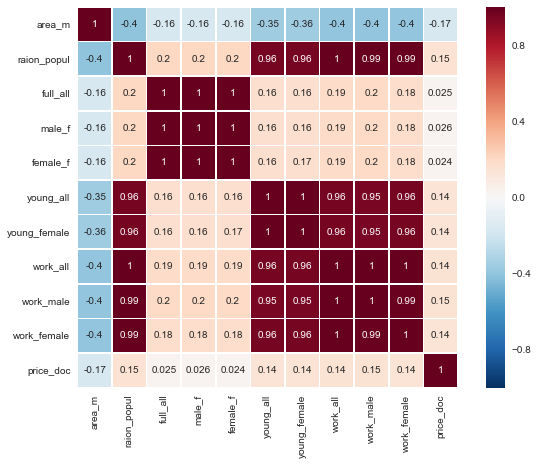

In [50]:
f, ax = plt.subplots(figsize=(10, 7))
plt.xticks(rotation='90')
sns.heatmap(corrmat, square=True, linewidths=.5, annot=True)

In [51]:
train_df['sub_area'].unique().shape[0]

146

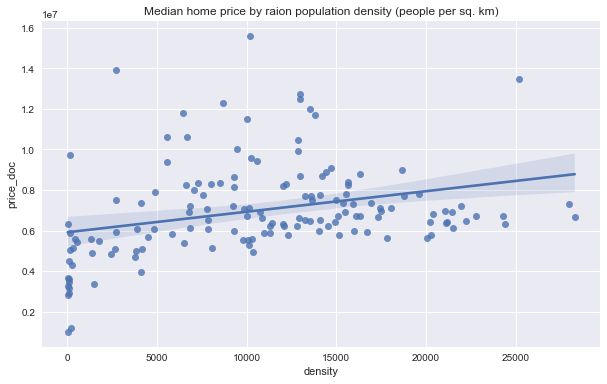

In [52]:
train_df['area_km'] = train_df['area_m'] / 1000000
train_df['density'] = train_df['raion_popul'] / train_df['area_km']

f, ax = plt.subplots(figsize=(10, 6))
sa_price = train_df.groupby('sub_area')[['density', 'price_doc']].median()
sns.regplot(x="density", y="price_doc", data=sa_price, scatter=True, truncate=True)
ax.set(title='Median home price by raion population density (people per sq. km)')

In [53]:
f, ax = plt.subplots(figsize=(10, 20))
sa_vc = train_df['sub_area'].value_counts()
sa_vc = pd.DataFrame({'sub_area':sa_vc.index, 'count': sa_vc.values})
ax = sns.barplot(x="count", y="sub_area", data=sa_vc, orient="h")
ax.set(title='Number of Transactions by District')
f.tight_layout()

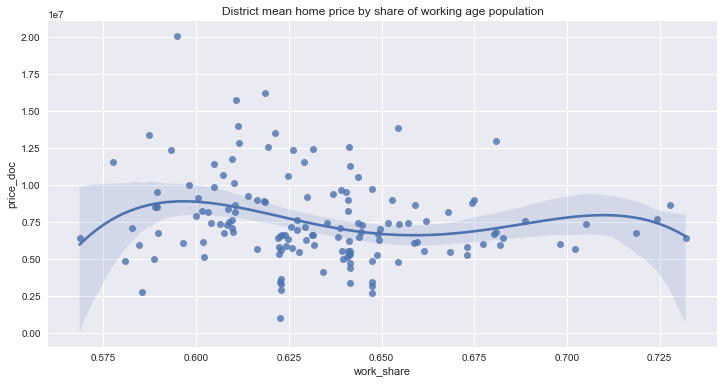

In [54]:
train_df['work_share'] = train_df['work_all'] / train_df['raion_popul']
f, ax = plt.subplots(figsize=(12, 6))
sa_price = train_df.groupby('sub_area')[['work_share', 'price_doc']].mean()
sns.regplot(x="work_share", y="price_doc", data=sa_price, scatter=True, order=4, truncate=True)
ax.set(title='District mean home price by share of working age population')

In [55]:
school_chars = ['children_preschool', 'preschool_quota', 'preschool_education_centers_raion', 'children_school', 
                'school_quota', 'school_education_centers_raion', 'school_education_centers_top_20_raion', 
                'university_top_20_raion', 'additional_education_raion', 'additional_education_km', 'university_km', 'price_doc']
corrmat = train_df[school_chars].corr()

In [56]:
#School Characteristics
f, ax = plt.subplots(figsize=(10, 7))
plt.xticks(rotation='90')
sns.heatmap(corrmat, square=True, linewidths=.5, annot=True)

C:\Users\seb\Anaconda3\envs\trade\lib\site-packages\seaborn\matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
C:\Users\seb\Anaconda3\envs\trade\lib\site-packages\seaborn\matrix.py:151: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


In [57]:
train_df['university_top_20_raion'].unique()

array([0, 2, 1, 3], dtype=int64)

C:\Users\seb\Anaconda3\envs\trade\lib\site-packages\seaborn\categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):
C:\Users\seb\Anaconda3\envs\trade\lib\site-packages\seaborn\categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


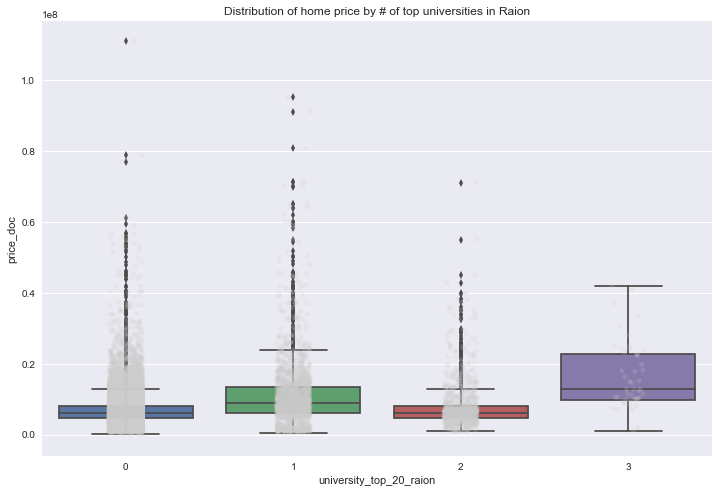

In [58]:
f, ax = plt.subplots(figsize=(12, 8))
sns.stripplot(x="university_top_20_raion", y="price_doc", data=train_df, jitter=True, alpha=.2, color=".8");
sns.boxplot(x="university_top_20_raion", y="price_doc", data=train_df)
ax.set(title='Distribution of home price by # of top universities in Raion', xlabel='university_top_20_raion', 
       ylabel='price_doc')

In [59]:
#Cultural/Recreational Characteristics
cult_chars = ['sport_objects_raion', 'culture_objects_top_25_raion', 'shopping_centers_raion', 'park_km', 'fitness_km', 
                'swim_pool_km', 'ice_rink_km','stadium_km', 'basketball_km', 'shopping_centers_km', 'big_church_km',
                'church_synagogue_km', 'mosque_km', 'theater_km', 'museum_km', 'exhibition_km', 'catering_km', 'price_doc']
corrmat = train_df[cult_chars].corr()

In [60]:
f, ax = plt.subplots(figsize=(12, 7))
plt.xticks(rotation='90')
sns.heatmap(corrmat, square=True, linewidths=.5, annot=True)

C:\Users\seb\Anaconda3\envs\trade\lib\site-packages\seaborn\matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
C:\Users\seb\Anaconda3\envs\trade\lib\site-packages\seaborn\matrix.py:151: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


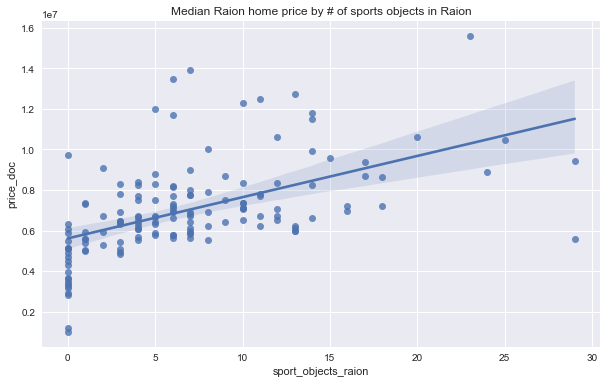

In [61]:
f, ax = plt.subplots(figsize=(10, 6))
so_price = train_df.groupby('sub_area')[['sport_objects_raion', 'price_doc']].median()
sns.regplot(x="sport_objects_raion", y="price_doc", data=so_price, scatter=True, truncate=True)
ax.set(title='Median Raion home price by # of sports objects in Raion')

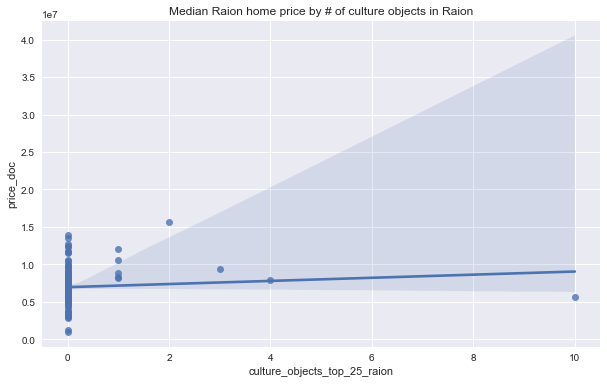

In [62]:
f, ax = plt.subplots(figsize=(10, 6))
co_price = train_df.groupby('sub_area')[['culture_objects_top_25_raion', 'price_doc']].median()
sns.regplot(x="culture_objects_top_25_raion", y="price_doc", data=co_price, scatter=True, truncate=True)
ax.set(title='Median Raion home price by # of culture objects in Raion')

In [63]:
train_df.groupby('culture_objects_top_25')['price_doc'].median()

culture_objects_top_25
no     6200000
yes    7400000
Name: price_doc, dtype: int64

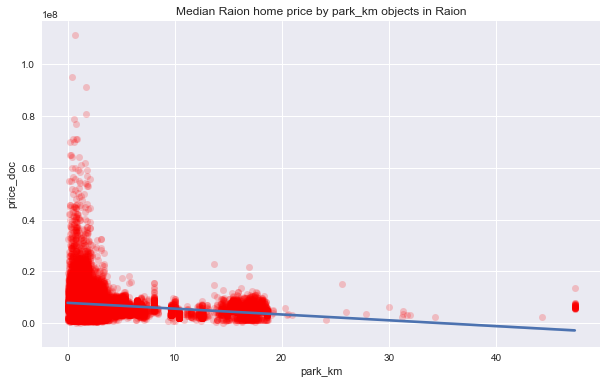

In [64]:
f, ax = plt.subplots(figsize=(10, 6))
sns.regplot(x="park_km", y="price_doc", data=train_df, scatter=True, truncate=True, scatter_kws={'color': 'r', 'alpha': .2})
ax.set(title='Median Raion home price by park_km objects in Raion')

In [65]:
#Infrastructure Features
inf_features = ['nuclear_reactor_km', 'thermal_power_plant_km', 'power_transmission_line_km', 'incineration_km',
                'water_treatment_km', 'incineration_km', 'railroad_station_walk_km', 'railroad_station_walk_min', 
                'railroad_station_avto_km', 'railroad_station_avto_min', 'public_transport_station_km', 
                'public_transport_station_min_walk', 'water_km', 'mkad_km', 'ttk_km', 'sadovoe_km','bulvar_ring_km',
                'kremlin_km', 'price_doc']
corrmat = train_df[inf_features].corr()

C:\Users\seb\Anaconda3\envs\trade\lib\site-packages\seaborn\matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
C:\Users\seb\Anaconda3\envs\trade\lib\site-packages\seaborn\matrix.py:151: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


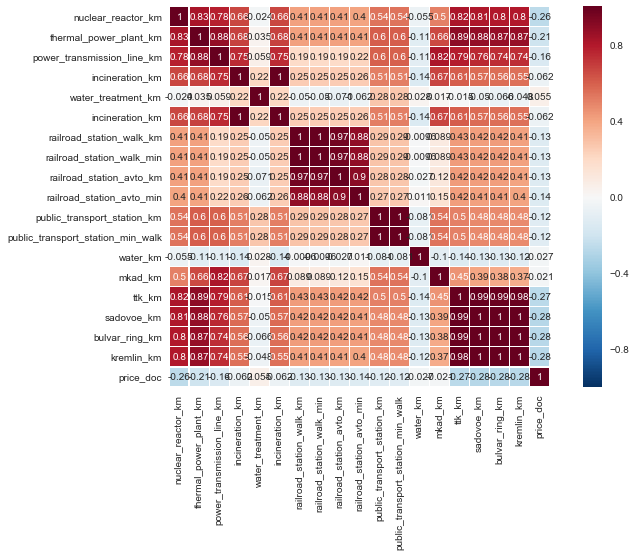

In [67]:
f, ax = plt.subplots(figsize=(12, 7))
plt.xticks(rotation='90')
sns.heatmap(corrmat, square=True, linewidths=.5, annot=True)

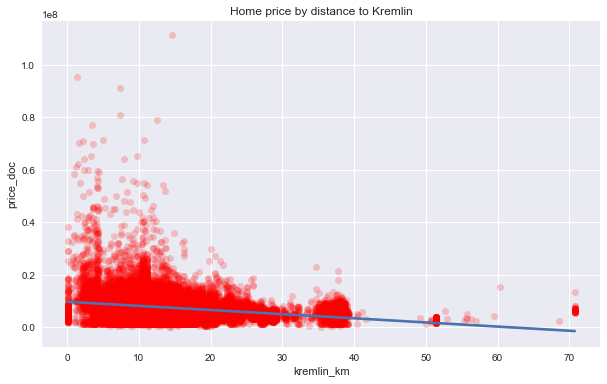

In [68]:
f, ax = plt.subplots(figsize=(10, 6))
sns.regplot(x="kremlin_km", y="price_doc", data=train_df, scatter=True, truncate=True, scatter_kws={'color': 'r', 'alpha': .2})
ax.set(title='Home price by distance to Kremlin')

In [70]:
#Variable Importance
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
X_train = train_df.drop(labels=['timestamp', 'id', 'incineration_raion'], axis=1).dropna()
y_train = X_train['price_doc']
X_train.drop('price_doc', axis=1, inplace=True)
for f in X_train.columns:
    if X_train[f].dtype == 'object':
        lbl = LabelEncoder()
        lbl.fit(X_train[f])
        X_train[f] = lbl.transform(X_train[f])
rf = RandomForestRegressor(random_state=0)
rf = rf.fit(X_train, y_train)

In [71]:
fi = list(zip(X_train.columns, rf.feature_importances_))
print('## rf variable importance')
d = [print('## %-40s%s' % (i)) for i in fi[:20]]

## rf variable importance
## full_sq                                 5.01611645798e-07
## life_sq                                 9.58359255845e-06
## floor                                   1.1860405674e-07
## max_floor                               8.25686685418e-07
## material                                6.40572009591e-07
## build_year                              8.0500835816e-08
## num_room                                3.00495362823e-07
## kitch_sq                                5.47288294401e-06
## state                                   5.32142244069e-07
## product_type                            2.14722233091e-07
## sub_area                                3.72839763326e-06
## area_m                                  0.001010193455
## raion_popul                             1.03799536405e-08
## green_zone_part                         3.42907021993e-07
## indust_part                             2.35636932757e-07
## children_preschool                      8.9100726093e-07
## p

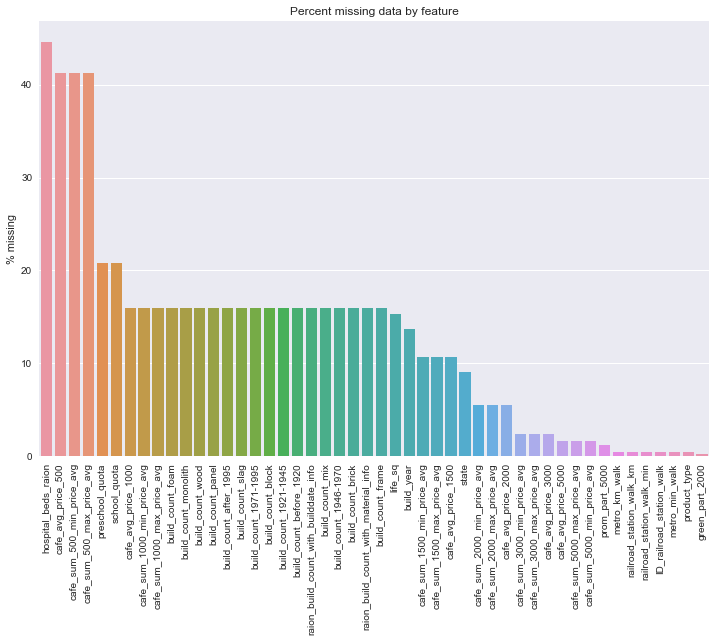

In [75]:
#Train vs Test Data
test_df = pd.read_csv(os.path.join(projectDir,"input/test.csv"), parse_dates=['timestamp'])
test_na = (test_df.isnull().sum() / len(test_df)) * 100
test_na = test_na.drop(test_na[test_na == 0].index).sort_values(ascending=False)

f, ax = plt.subplots(figsize=(12, 8))
plt.xticks(rotation='90')
sns.barplot(x=test_na.index, y=test_na)
ax.set(title='Percent missing data by feature', ylabel='% missing')

In [76]:
all_data = pd.concat([train_df.drop('price_doc', axis=1), test_df])
all_data['dataset'] = ''
l = len(train_df)
all_data.iloc[:l]['dataset'] = 'train'
all_data.iloc[l:]['dataset'] = 'test'
train_dataset = all_data['dataset'] == 'train'

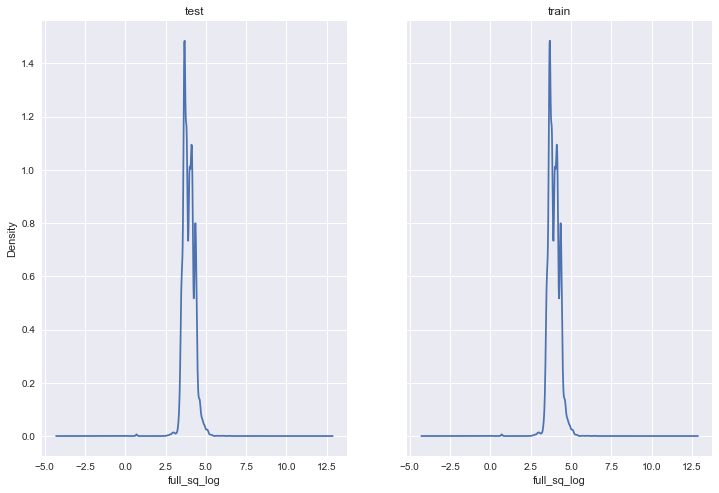

In [79]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8), sharey=True)
all_data['full_sq_log'] = np.log1p(all_data['full_sq'])
all_data.drop(train_dataset)["full_sq_log"].plot.kde(ax=ax[0])
all_data.drop(~train_dataset)["full_sq_log"].plot.kde(ax=ax[1])
ax[0].set(title='test', xlabel='full_sq_log')
ax[1].set(title='train', xlabel='full_sq_log')

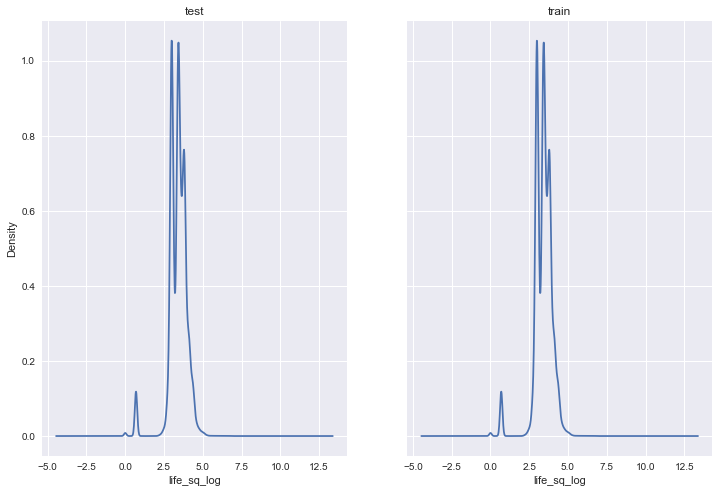

In [80]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8), sharey=True)
all_data['life_sq_log'] = np.log1p(all_data['life_sq'])
all_data.drop(train_dataset)["life_sq_log"].plot.kde(ax=ax[0])
all_data.drop(~train_dataset)["life_sq_log"].plot.kde(ax=ax[1])
ax[0].set(title='test', xlabel='life_sq_log')
ax[1].set(title='train', xlabel='life_sq_log')

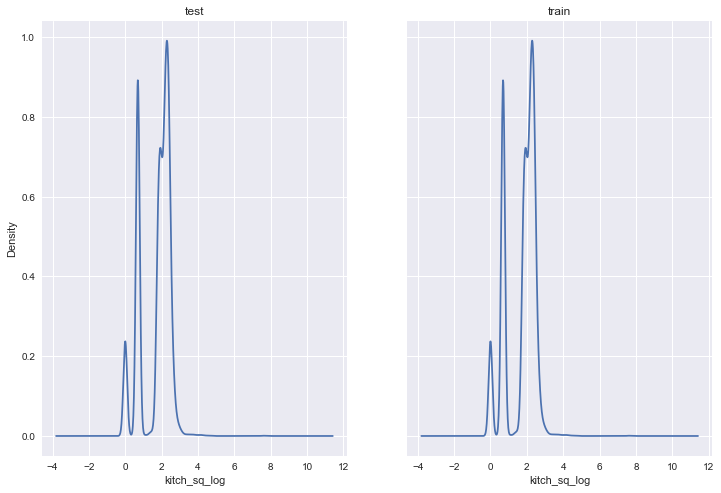

In [81]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8), sharey=True)
all_data['kitch_sq_log'] = np.log1p(all_data['kitch_sq'])
all_data.drop(train_dataset)["kitch_sq_log"].plot.kde(ax=ax[0])
all_data.drop(~train_dataset)["kitch_sq_log"].plot.kde(ax=ax[1])
ax[0].set(title='test', xlabel='kitch_sq_log')
ax[1].set(title='train', xlabel='kitch_sq_log')

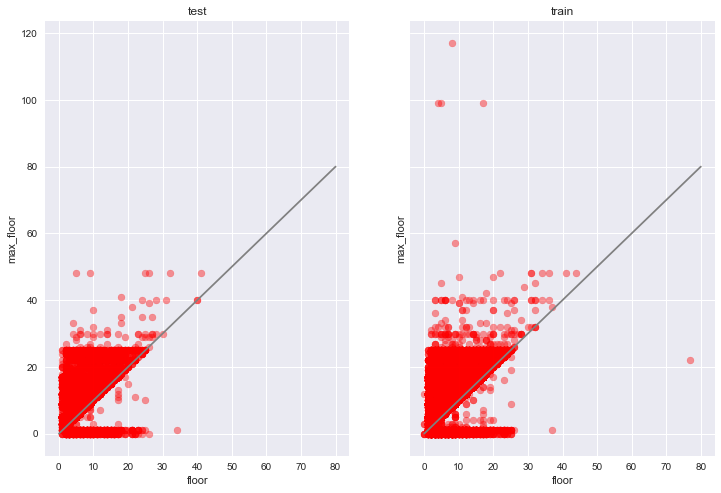

In [82]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8), sharey=True)
ax[0].scatter(x=test_df['floor'], y=test_df['max_floor'], c='r', alpha=0.4)
ax[0].plot([0, 80], [0, 80], color='.5')
ax[1].scatter(x=train_df['floor'], y=train_df['max_floor'], c='r', alpha=0.4)
ax[1].plot([0, 80], [0, 80], color='.5')
ax[0].set(title='test', xlabel='floor', ylabel='max_floor')
ax[1].set(title='train', xlabel='floor', ylabel='max_floor')

TypeError: unsupported operand type(s) for -: 'str' and 'float'

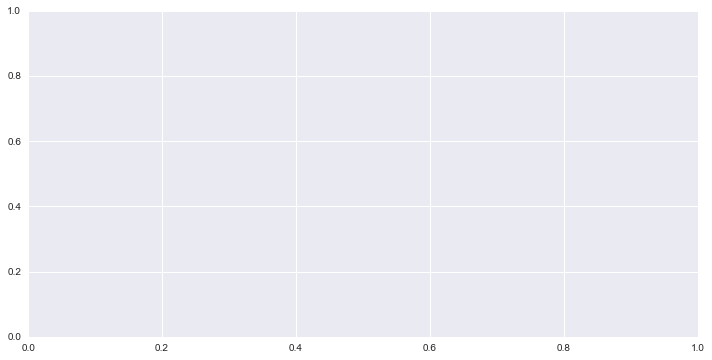

In [83]:
years = mdates.YearLocator()   # every year
yearsFmt = mdates.DateFormatter('%Y')
ts_vc_train = train_df['timestamp'].value_counts()
ts_vc_test = test_df['timestamp'].value_counts()
f, ax = plt.subplots(figsize=(12, 6))
plt.bar(left=ts_vc_train.index, height=ts_vc_train)
plt.bar(left=ts_vc_test.index, height=ts_vc_test)
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.set(title='Number of transactions by day', ylabel='count')

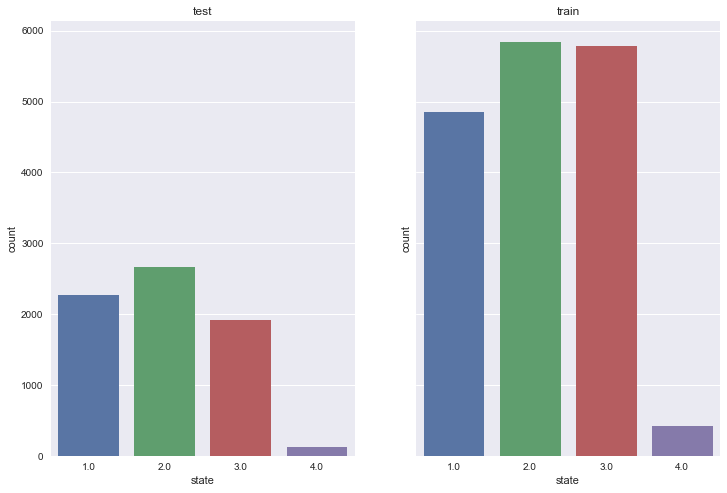

In [84]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8), sharey=True)
sns.countplot(x=test_df['state'], ax=ax[0])
sns.countplot(x=train_df['state'], ax=ax[1])
ax[0].set(title='test', xlabel='state')
ax[1].set(title='train', xlabel='state')

In [85]:
train_df.head()

In [87]:
train_df = pd.read_csv(os.path.join(projectDir,"input/train.csv"), parse_dates=['timestamp'])
test_df = pd.read_csv(os.path.join(projectDir,"input/test.csv"), parse_dates=['timestamp'])
macro_df = pd.read_csv(os.path.join(projectDir,"input/macro.csv"), parse_dates=['timestamp'])
train_df = pd.merge(train_df, macro_df, how='left', on='timestamp')
test_df = pd.merge(test_df, macro_df, how='left', on='timestamp')
print(train_df.shape, test_df.shape)

# truncate the extreme values in price_doc #
ulimit = np.percentile(train_df.price_doc.values, 99)
llimit = np.percentile(train_df.price_doc.values, 1)
train_df['price_doc'].ix[train_df['price_doc']>ulimit] = ulimit
train_df['price_doc'].ix[train_df['price_doc']<llimit] = llimit

(30471, 391) (7662, 390)


C:\Users\seb\Anaconda3\envs\trade\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  # This is added back by InteractiveShellApp.init_path()
C:\Users\seb\Anaconda3\envs\trade\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  if sys.path[0] == '':


In [88]:
train_df["price_doc"].head(1)

0    5850000.0
Name: price_doc, dtype: float64

In [89]:
for f in train_df.columns:
    if train_df[f].dtype=='object':
        print(f)
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train_df[f].values.astype('str')) + list(test_df[f].values.astype('str')))
        train_df[f] = lbl.transform(list(train_df[f].values.astype('str')))
        test_df[f] = lbl.transform(list(test_df[f].values.astype('str')))

product_type
sub_area


culture_objects_top_25
thermal_power_plant_raion
incineration_raion


oil_chemistry_raion
radiation_raion
railroad_terminal_raion


big_market_raion
nuclear_reactor_raion
detention_facility_raion


water_1line
big_road1_1line
railroad_1line


ecology
child_on_acc_pre_school
modern_education_share


old_education_build_share


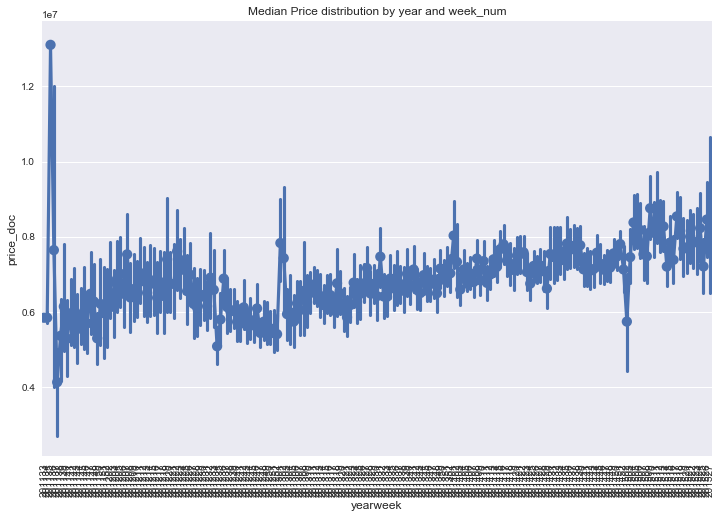

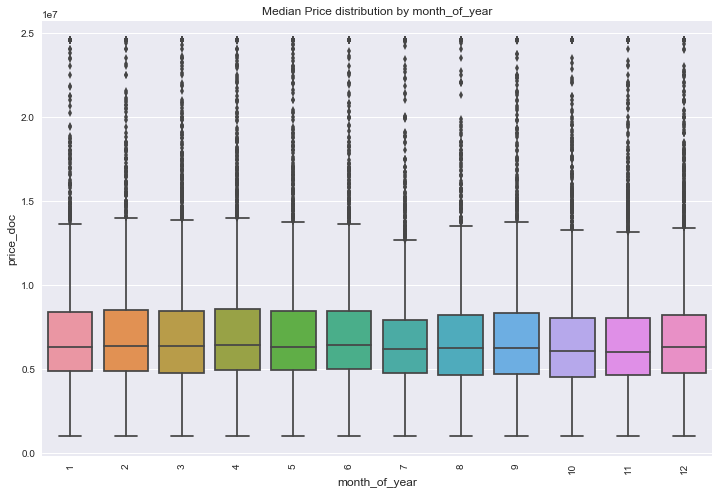

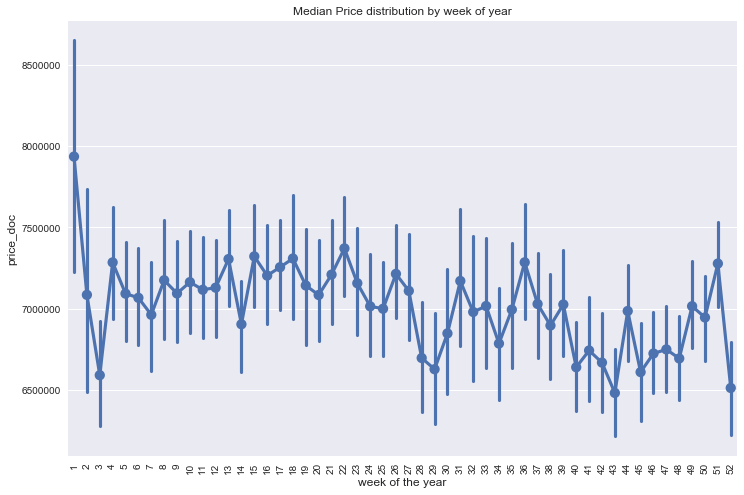

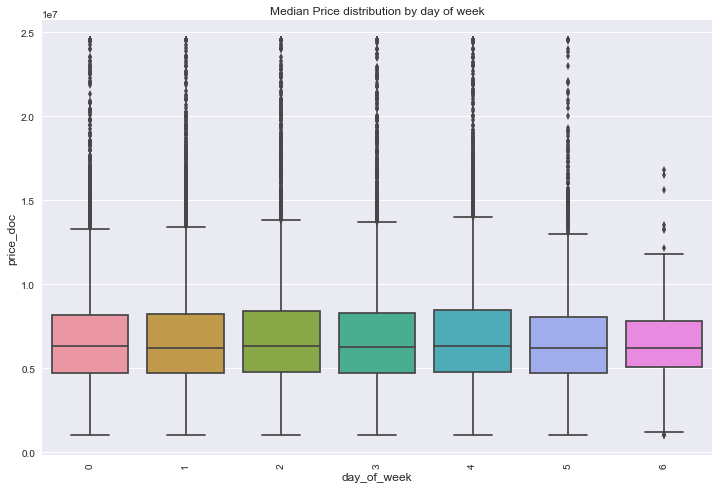

In [90]:
# year and month #
train_df["yearmonth"] = train_df["timestamp"].dt.year*100 + train_df["timestamp"].dt.month
test_df["yearmonth"] = test_df["timestamp"].dt.year*100 + test_df["timestamp"].dt.month

# year and week #
train_df["yearweek"] = train_df["timestamp"].dt.year*100 + train_df["timestamp"].dt.weekofyear
test_df["yearweek"] = test_df["timestamp"].dt.year*100 + test_df["timestamp"].dt.weekofyear

# year #
train_df["year"] = train_df["timestamp"].dt.year
test_df["year"] = test_df["timestamp"].dt.year

# month of year #
train_df["month_of_year"] = train_df["timestamp"].dt.month
test_df["month_of_year"] = test_df["timestamp"].dt.month

# week of year #
train_df["week_of_year"] = train_df["timestamp"].dt.weekofyear
test_df["week_of_year"] = test_df["timestamp"].dt.weekofyear

# day of week #
train_df["day_of_week"] = train_df["timestamp"].dt.weekday
test_df["day_of_week"] = test_df["timestamp"].dt.weekday


plt.figure(figsize=(12,8))
sns.pointplot(x='yearweek', y='price_doc', data=train_df)
plt.ylabel('price_doc', fontsize=12)
plt.xlabel('yearweek', fontsize=12)
plt.title('Median Price distribution by year and week_num')
plt.xticks(rotation='vertical')
plt.show()

plt.figure(figsize=(12,8))
sns.boxplot(x='month_of_year', y='price_doc', data=train_df)
plt.ylabel('price_doc', fontsize=12)
plt.xlabel('month_of_year', fontsize=12)
plt.title('Median Price distribution by month_of_year')
plt.xticks(rotation='vertical')
plt.show()

plt.figure(figsize=(12,8))
sns.pointplot(x='week_of_year', y='price_doc', data=train_df)
plt.ylabel('price_doc', fontsize=12)
plt.xlabel('week of the year', fontsize=12)
plt.title('Median Price distribution by week of year')
plt.xticks(rotation='vertical')
plt.show()

plt.figure(figsize=(12,8))
sns.boxplot(x='day_of_week', y='price_doc', data=train_df)
plt.ylabel('price_doc', fontsize=12)
plt.xlabel('day_of_week', fontsize=12)
plt.title('Median Price distribution by day of week')
plt.xticks(rotation='vertical')
plt.show()

In [91]:
# ratio of living area to full area #
train_df["ratio_life_sq_full_sq"] = train_df["life_sq"] / np.maximum(train_df["full_sq"].astype("float"),1)
test_df["ratio_life_sq_full_sq"] = test_df["life_sq"] / np.maximum(test_df["full_sq"].astype("float"),1)
train_df["ratio_life_sq_full_sq"].ix[train_df["ratio_life_sq_full_sq"]<0] = 0
train_df["ratio_life_sq_full_sq"].ix[train_df["ratio_life_sq_full_sq"]>1] = 1
test_df["ratio_life_sq_full_sq"].ix[test_df["ratio_life_sq_full_sq"]<0] = 0
test_df["ratio_life_sq_full_sq"].ix[test_df["ratio_life_sq_full_sq"]>1] = 1

# ratio of kitchen area to living area #
train_df["ratio_kitch_sq_life_sq"] = train_df["kitch_sq"] / np.maximum(train_df["life_sq"].astype("float"),1)
test_df["ratio_kitch_sq_life_sq"] = test_df["kitch_sq"] / np.maximum(test_df["life_sq"].astype("float"),1)
train_df["ratio_kitch_sq_life_sq"].ix[train_df["ratio_kitch_sq_life_sq"]<0] = 0
train_df["ratio_kitch_sq_life_sq"].ix[train_df["ratio_kitch_sq_life_sq"]>1] = 1
test_df["ratio_kitch_sq_life_sq"].ix[test_df["ratio_kitch_sq_life_sq"]<0] = 0
test_df["ratio_kitch_sq_life_sq"].ix[test_df["ratio_kitch_sq_life_sq"]>1] = 1

# ratio of kitchen area to full area #
train_df["ratio_kitch_sq_full_sq"] = train_df["kitch_sq"] / np.maximum(train_df["full_sq"].astype("float"),1)
test_df["ratio_kitch_sq_full_sq"] = test_df["kitch_sq"] / np.maximum(test_df["full_sq"].astype("float"),1)
train_df["ratio_kitch_sq_full_sq"].ix[train_df["ratio_kitch_sq_full_sq"]<0] = 0
train_df["ratio_kitch_sq_full_sq"].ix[train_df["ratio_kitch_sq_full_sq"]>1] = 1
test_df["ratio_kitch_sq_full_sq"].ix[test_df["ratio_kitch_sq_full_sq"]<0] = 0
test_df["ratio_kitch_sq_full_sq"].ix[test_df["ratio_kitch_sq_full_sq"]>1] = 1

C:\Users\seb\Anaconda3\envs\trade\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  after removing the cwd from sys.path.
C:\Users\seb\Anaconda3\envs\trade\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  """
C:\Users\seb\Anaconda3\envs\trade\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  
C:\Users\seb\Anaconda3\envs\trade\lib\site-packages\ipykernel_launcher.py:7: D

C:\Users\seb\Anaconda3\envs\trade\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  del sys.path[0]
C:\Users\seb\Anaconda3\envs\trade\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  
C:\Users\seb\Anaconda3\envs\trade\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  from ipykernel import kernelapp as app
C:\Users\seb\Anaconda3\envs\trade\lib\site-packages\ipykernel_

In [92]:
# floor of the house to the total number of floors in the house #
train_df["ratio_floor_max_floor"] = train_df["floor"] / train_df["max_floor"].astype("float")
test_df["ratio_floor_max_floor"] = test_df["floor"] / test_df["max_floor"].astype("float")

# num of floor from top #
train_df["floor_from_top"] = train_df["max_floor"] - train_df["floor"]
test_df["floor_from_top"] = test_df["max_floor"] - test_df["floor"]

train_df["extra_sq"] = train_df["full_sq"] - train_df["life_sq"]
test_df["extra_sq"] = test_df["full_sq"] - test_df["life_sq"]

train_df["age_of_building"] = train_df["build_year"] - train_df["year"]
test_df["age_of_building"] = test_df["build_year"] - test_df["year"]

In [93]:
def add_count(df, group_col):
    grouped_df = df.groupby(group_col)["id"].aggregate("count").reset_index()
    grouped_df.columns = [group_col, "count_"+group_col]
    df = pd.merge(df, grouped_df, on=group_col, how="left")
    return df

train_df = add_count(train_df, "yearmonth")
test_df = add_count(test_df, "yearmonth")

train_df = add_count(train_df, "yearweek")
test_df = add_count(test_df, "yearweek")

train_df["ratio_preschool"] = train_df["children_preschool"] / train_df["preschool_quota"].astype("float")
test_df["ratio_preschool"] = test_df["children_preschool"] / test_df["preschool_quota"].astype("float")

train_df["ratio_school"] = train_df["children_school"] / train_df["school_quota"].astype("float")
test_df["ratio_school"] = test_df["children_school"] / test_df["school_quota"].astype("float")

In [94]:
y_train = train_df["price_doc"]
x_train = train_df.drop(["id", "timestamp", "price_doc"], axis=1)
x_test = test_df.drop(["id", "timestamp"], axis=1)

test_id=test_df.id

In [95]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_test)

In [96]:
cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=1000, 
                   early_stopping_rounds=20,
    verbose_eval=50, show_stdv=False)
cv_output[['train-rmse-mean', 'test-rmse-mean']].plot()

[0]	train-rmse:7.68763e+06	test-rmse:7.68917e+06


KeyboardInterrupt: 

In [ ]:
num_boost_rounds = len(cv_output)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round= num_boost_rounds)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 13))
xgb.plot_importance(model, max_num_features=50, height=0.5, ax=ax)

In [ ]:
y_predict = model.predict(dtest)
output = pd.DataFrame({'id': test_id, 'price_doc': y_predict})
output.head()

In [ ]:
output.to_csv('xgbSub.csv', index=False)